In [1]:
# https://www.kaggle.com/uciml/sms-spam-collection-dataset

### Importing libraries and downloads

In [2]:
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from wordcloud import WordCloud

In [3]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nirajan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Loading dataset and analyzing

In [4]:
df = pd.read_csv('datasets/spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.shape

(5572, 5)

In [7]:
df['Unnamed: 2'].notna().sum(), df['Unnamed: 3'].notna().sum(), df['Unnamed: 4'].notna().sum()

(50, 12, 6)

In [8]:
df[df['Unnamed: 3'].isna() == False].head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
2170,ham,\CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER...,JUST REALLYNEED 2DOCD.PLEASE DONTPLEASE DONTIG...,"U NO THECD ISV.IMPORTANT TOME 4 2MORO\""""",NaN


In [9]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [10]:
df['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

Text(0.5, 1.0, 'Labels')

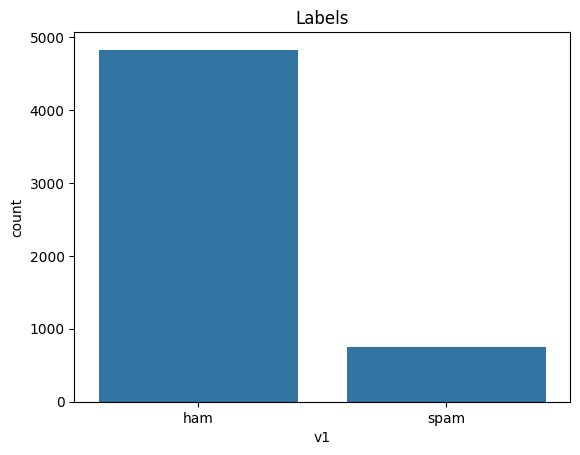

In [11]:
sns.barplot(df['v1'].value_counts());
plt.title('Labels')

In [12]:
df.columns = ['labels', 'data']

In [13]:
df['labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [14]:
df.head()

,labels,data
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
df_copy = df.copy(deep=True)

### Lemmatizing the dataset with pos tagging

In [16]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
lemmatizer = WordNetLemmatizer()

In [18]:
mail_sample = df.iloc[0, 1]
mail_sample

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [19]:
tokens = mail_sample.translate(str.maketrans('','',string.punctuation)).lower().split()
# tokens = mail_sample.split()
tokens

['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'wat']

In [20]:
words_and_tags = nltk.pos_tag(tokens)
words_and_tags

[('go', 'VB'),
 ('until', 'IN'),
 ('jurong', 'JJ'),
 ('point', 'NN'),
 ('crazy', 'NN'),
 ('available', 'JJ'),
 ('only', 'RB'),
 ('in', 'IN'),
 ('bugis', 'NN'),
 ('n', 'RB'),
 ('great', 'JJ'),
 ('world', 'NN'),
 ('la', 'NN'),
 ('e', 'VBP'),
 ('buffet', 'JJ'),
 ('cine', 'NN'),
 ('there', 'EX'),
 ('got', 'VBD'),
 ('amore', 'RB'),
 ('wat', 'JJ')]

In [21]:
lematized_words = []
for token, tag in words_and_tags:
        word = lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag))
        if word not in lematized_words:
            lematized_words.append(word)

In [22]:
' '.join(lematized_words)

'go until jurong point crazy available only in bugis n great world la e buffet cine there get amore wat'

In [23]:
def lema(mail):
    tokens = mail.translate(str.maketrans('','',string.punctuation)).lower().split()
    # tokens = mail.split()
    words_and_tags = nltk.pos_tag(tokens)
    lematized_words = []
    for token, tag in words_and_tags:
        word = lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag))
        if word not in lematized_words:
            lematized_words.append(word)

    return ' '.join(lematized_words)

In [24]:
df['data'] = df['data'].apply(lema)

In [25]:
df.head()

,labels,data
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor c already then
4,0,nah i dont think he go to usf live around here...


### Divinding the dataset into train and test set

In [26]:
X = df['data']
y = df.drop('data', axis = 1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

### Converting data into TF-IDF

In [28]:
vectorizer = TfidfVectorizer(decode_error='ignore')

In [29]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Model Training with TF-IDF

In [30]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

C:\Users\Nirajan\Desktop\Artificial Intelligence\NLP_Udemy\env\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [31]:
print("train acc:", clf.score(X_train_tfidf, y_train))
print("test acc:", clf.score(X_test_tfidf, y_test))

train acc: 0.964824120603015
test acc: 0.9468772433596554


In [32]:
y_pred_train = clf.predict(X_train_tfidf)
y_pred = clf.predict(X_test_tfidf)

In [33]:
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)

print('Train:')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Test:')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Train:
Precision: 1.0
Recall: 0.7375
F1-score: 0.8489208633093526

Test:
Precision: 1.0
Recall: 0.6042780748663101
F1-score: 0.7533333333333333


In [34]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred)

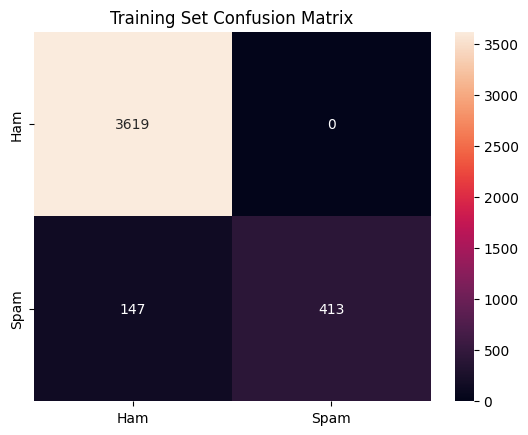

In [35]:
sns.heatmap(cm_train, annot = True, fmt= '')
plt.title('Training Set Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=["Ham", "Spam"])
plt.yticks(ticks=[0.5, 1.5], labels=["Ham", "Spam"]);

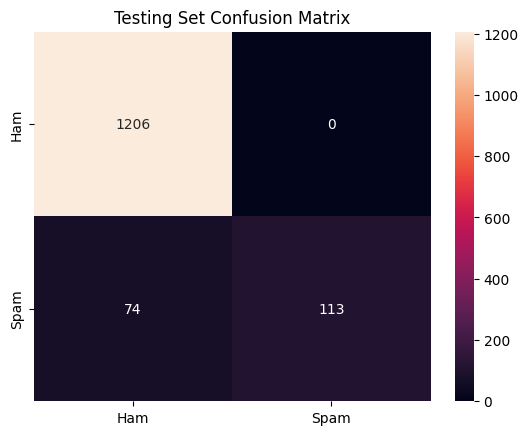

In [36]:
sns.heatmap(cm_test, annot = True, fmt= '')
plt.title('Testing Set Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=["Ham", "Spam"])
plt.yticks(ticks=[0.5, 1.5], labels=["Ham", "Spam"]);

### Trying with Count Vectorier

In [37]:
count_vectorizer = CountVectorizer(decode_error='ignore')

In [38]:
X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)

### Model Training with count vectorizer

In [39]:
clf1 = MultinomialNB()
clf1.fit(X_train_cv, y_train)

C:\Users\Nirajan\Desktop\Artificial Intelligence\NLP_Udemy\env\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [40]:
print("train acc:", clf.score(X_train_cv, y_train))
print("test acc:", clf.score(X_test_cv, y_test))

train acc: 0.9712849964106246
test acc: 0.9562096195262024


In [41]:
y_pred_train = clf1.predict(X_train_cv)
y_pred = clf1.predict(X_test_cv)

In [42]:
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)

print('Train:')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Test:')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Train:
Precision: 0.981651376146789
Recall: 0.9553571428571429
F1-score: 0.9683257918552036

Test:
Precision: 0.9771428571428571
Recall: 0.9144385026737968
F1-score: 0.9447513812154696


In [43]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred)

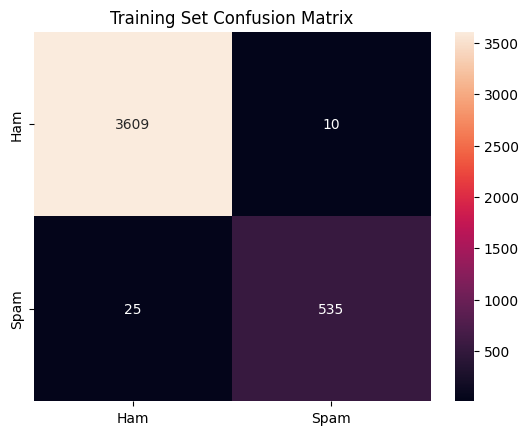

In [44]:
sns.heatmap(cm_train, annot = True, fmt= '')
plt.title('Training Set Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=["Ham", "Spam"])
plt.yticks(ticks=[0.5, 1.5], labels=["Ham", "Spam"]);

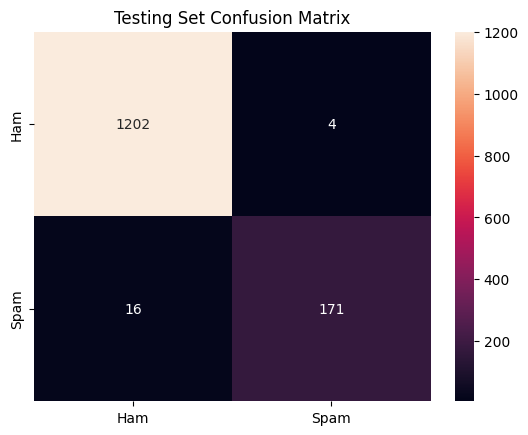

In [45]:
sns.heatmap(cm_test, annot = True, fmt= '')
plt.title('Testing Set Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=["Ham", "Spam"])
plt.yticks(ticks=[0.5, 1.5], labels=["Ham", "Spam"]);

### Visualizing the data

In [47]:
def visualize(label):
    label = 1 if 'spam' else 0
    words = ''
    for msg in df[df['labels'] == label]['data']:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

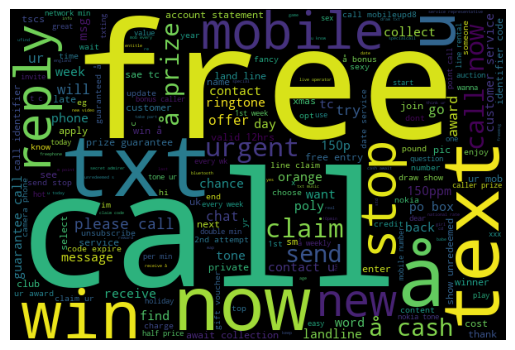

In [48]:
visualize('spam')

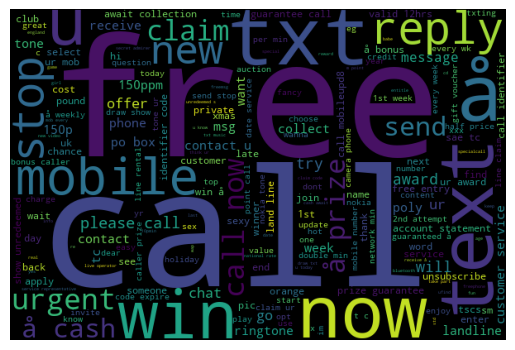

In [49]:
visualize('ham')

### See what we're getting wrong

In [50]:
X = count_vectorizer.transform(df['data'])
df_copy['predictions'] = clf1.predict(X)

**Things that should be spam**

In [51]:
sneaky_spam = df_copy[(df_copy['predictions'] == 0) & (df_copy['labels'] == 1)]['data']
for msg in sneaky_spam:
  print(msg)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES
Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
How about getting in touch with folks waiting for company? Just txt back your NAME and AGE to opt in! Enjoy the community (150p/SMS)
Filthy stories and GIRLS waiting for your
Dont forget you can place as many FREE Requests with 1stchoice.co.uk as yo

**Things that should not be spam**

In [52]:
not_actually_spam = df_copy[(df_copy['predictions'] == 1) & (df_copy['labels'] == 0)]['data']
for msg in not_actually_spam:
  print(msg)

Finally the match heading towards draw as your prediction.
Are you free now?can i call now?
26th OF JULY
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May
Total video converter free download type this in google search:)
Madam,regret disturbance.might receive a reference check from DLF Premarica.kindly be informed.Rgds,Rakhesh,Kerala.
Hmmm:)how many players selected?
Mostly sports type..lyk footbl,crckt..
Received, understood n acted upon!
I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;
S.this will increase the chance of winning.
Nokia phone is lovly..
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
